#Data Dictionnary

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import libraries


In [2]:
# Importing the libraries 
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
import matplotlib.pyplot as plt

import math

# import graph objects as "go"
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px
import plotly.figure_factory as ff


%matplotlib inline

# Data Exploration

In [3]:
data=pd.read_csv('/content/drive/My Drive/AE_PJ/clinical_trial.csv')
data.head()

,title,abstract,trial
0,Treatment of Hodgkin's disease and other cance...,NaN,1
1,Cell mediated immune status in malignancy--pre...,Twenty-eight cases of malignancies of differen...,0
2,Neoadjuvant vinorelbine-capecitabine versus do...,"BACKGROUND: Among breast cancer patients, nonr...",1
3,"Randomized phase 3 trial of fluorouracil, epir...",BACKGROUND: Taxanes are among the most active ...,1
4,Is first-line single-agent mitoxantrone in the...,BACKGROUND: To determine whether patients with...,1


In [4]:
data.count()

title       1860
abstract    1748
trial       1860
dtype: int64

In [5]:
data.shape

(1860, 3)

##Problem 1 - Loading the Dataset

**Q1:** How many characters are there in the longest abstract?


**A1:**  3708

In [6]:
length_abstract = data.abstract.str.len()
max(length_abstract[1: len(length_abstract)])

3708.0

**Q2:**  How many search results provided no abstract?

**A2:** 112

In [7]:
data.isnull().sum()

title         0
abstract    112
trial         0
dtype: int64

**Q3:** Find the observation with the minimum number of characters in the title (the variable "title") out of all of the observations in this dataset. 

**A3:** 


In [10]:
length_title= data.title.str.len()
for i in range(0, len(length_title)): 
  if (length_title[i] == min(length_title) ) : print( data.at[i,'title'])

A decade of letrozole: FACE.


##Problem 2: Data Pre-Processing

In [11]:
#Preparing the Corpus
corpusTitle = data['title']
corpusAbstract = data['abstract']

#Convert data to lower case
corpusTitle = data['title'].str.lower()
corpusAbstract = data['abstract'].str.lower()

In [12]:
#Remove punctuation 
corpusTitle = corpusTitle.str.replace('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n]','')
corpusAbstract = corpusAbstract.str.replace('[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n]','')

In [13]:
# corpusTitle.head()
corpusAbstract.head()

0                                                  NaN
1    twentyeight cases of malignancies of different...
2    background among breast cancer patients nonres...
3    background taxanes are among the most active d...
4    background to determine whether patients with ...
Name: abstract, dtype: object

In [14]:
#Removing Stop words and stemming

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords 
nltk.download('stopwords') 

from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer()

# Define the stopwords list
my_stopwords = set(stopwords.words('english'))

#function to remove stop words
def remove_stop_words(data):
    stop_words = my_stopwords
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text
    
#stemming function
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
corpusTitle= corpusTitle.apply(remove_stop_words).apply(stem_sentences)
corpusTitle.head()

0    treatment hodgkin 's diseas cancer 13bis2chlor...
1    cell mediat immun statu malignancypretherapi p...
2    neoadjuv vinorelbinecapecitabin versu docetaxe...
3    random phase trial fluorouracil epirubicin cyc...
4    firstlin singleag mitoxantron treatment highri...
Name: title, dtype: object

In [16]:
corpusAbstract= corpusAbstract.apply(remove_stop_words).apply(stem_sentences)
corpusAbstract.head()

0                                                  nan
1    twentyeight case malign differ kind studi asse...
2    background among breast cancer patient nonresp...
3    background taxan among activ drug treatment me...
4    background determin whether patient highrisk m...
Name: abstract, dtype: object

In [17]:
#vect / feature selection

from sklearn.feature_extraction.text import CountVectorizer

vectTitle = CountVectorizer(min_df=0.05)
vectTitle.fit(corpusTitle)
XTitle = vectTitle.fit_transform(corpusTitle)

dtmTitle = pd.DataFrame(XTitle.toarray(), columns=vectTitle.get_feature_names())

In [18]:
vectAbstract = CountVectorizer(min_df=0.05)
vectAbstract.fit(corpusAbstract)
XAbstract= vectAbstract.fit_transform(corpusAbstract)

dtmAbstract = pd.DataFrame(XAbstract.toarray(), columns=vectAbstract.get_feature_names())

**Q1:** How many terms remain in dtmTitle after removing sparse terms (aka how many columns does it have)?

**A1:** : 32


In [19]:
dtmTitle.head()
dtmTitle.shape
# dtmTitle.columns.shape

(1860, 32)

**Q2:** How many terms remain in dtmTitle after removing sparse terms (aka how many columns does it have)?

**A2:** : 390

In [20]:
dtmAbstract.head()
dtmAbstract.shape

(1860, 390)

**Q3:** What is the most likely reason why dtmAbstract has so many more terms than dtmTitle?

**A3:** Abstracts have more words than title. Titles tend to be short.

**Q4:** What is the most frequent word stem across all the abstracts? Hint: you can use colSums() to compute the frequency of a word across all the abstracts.

**A4:** Patient

In [21]:
for col in dtmAbstract.columns : 
  if dtmAbstract.sum(axis=0)[col] == max(dtmAbstract.sum(axis=0)) : print(col)

patient


##Problem 3: Building a model


In [22]:
#Adding the letter T in front of all the title variable names and A in front of abstract
dtmTitle.columns = ['T'+str(col)  for col in dtmTitle.columns]
dtmAbstract.columns = ['A'+str(col)  for col in dtmAbstract.columns]

In [23]:
dtmAbstract.shape

(1860, 390)

In [24]:
dtmTitle.shape

(1860, 32)

In [25]:
dt1 = dtmTitle.join(dtmAbstract)

In [26]:
dtm = dt1.join(data['trial'])

In [27]:
dtm.shape

(1860, 423)

In [28]:
#Splitting data
X = dtm.drop('trial', axis = 1)
Y = data['trial']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3,random_state=42)

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1302, 422), (558, 422), (1302,), (558,))

#### CART Model

In [31]:
#Build CART Model
from sklearn.tree import  DecisionTreeClassifier
dtr = DecisionTreeClassifier(max_depth = 10)
dtr.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

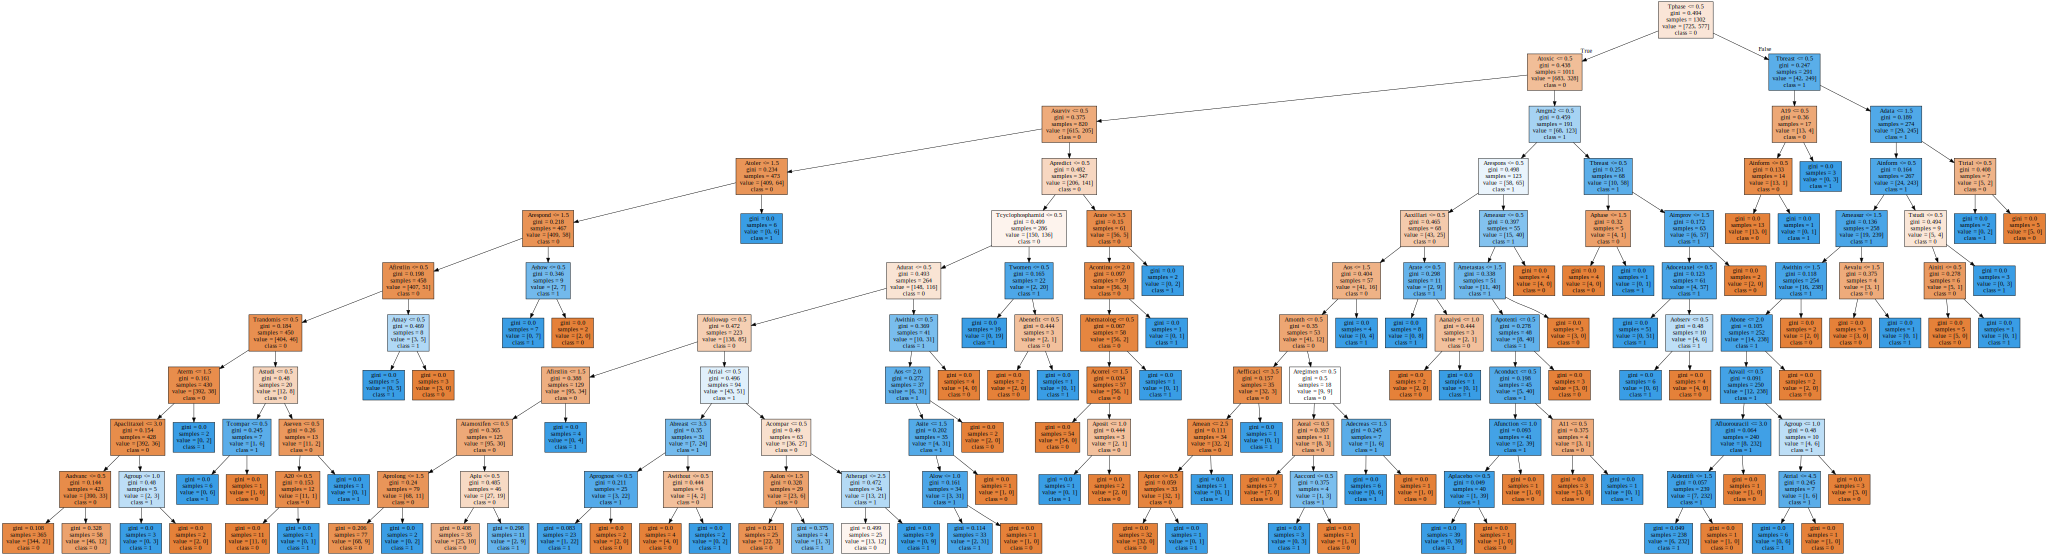

In [32]:
import graphviz

graphviz.Source(export_graphviz(dtr,
                                feature_names=X.columns,
                                filled=True,class_names=["0","1"]))

In [33]:
from sklearn.metrics import roc_curve, roc_auc_score

##Problem 4: Evaluating the model

###On training set

In [34]:

train_prediction = dtr.predict(X_train)

In [35]:
print('The mean absolute error',metrics.mean_absolute_error(y_train, train_prediction))
print('The accuracy:',metrics.accuracy_score(y_train, train_prediction))

The mean absolute error 0.060675883256528416
The accuracy: 0.9393241167434716


In [36]:
fpr, tpr, _ = roc_curve(y_train, train_prediction)

fig = px.line(x=fpr, y=tpr, title='ROC curve training set')
fig.show()

print('The AUC value on the training set is', roc_auc_score(y_train, train_prediction) )

The AUC value on the training set is 0.9336652124544315


###On testing set

In [37]:
test_prediction = dtr.predict(X_test)

In [38]:
print('The Mean absolute error',metrics.mean_absolute_error(y_test, test_prediction))
print("The accuracy:",metrics.accuracy_score(y_test, test_prediction))

The Mean absolute error 0.25089605734767023
The accuracy: 0.7491039426523297


In [39]:
fpr, tpr, _ = roc_curve(y_test, test_prediction)

fig = px.line(x=fpr, y=tpr, title='ROC curve training set')
fig.show()

print('The AUC value on the training set is', roc_auc_score(y_test, test_prediction) )

The AUC value on the training set is 0.7359276729559748


##Problem 5: Decision-Maker Tradeoffs

The decision maker for this problem, a researcher performing a review of the medical literature, would use a model (like the CART one we built here) in the following workflow:

1) For all of the papers retreived in the PubMed Search, predict which papers are clinical trials using the model. This yields some initial Set A of papers predicted to be trials, and some Set B of papers predicted not to be trials. (See the figure below.)

2) Then, the decision maker manually reviews all papers in Set A, verifying that each paper meets the study's detailed inclusion criteria (for the purposes of this analysis, we assume this manual review is 100% accurate at identifying whether a paper in Set A is relevant to the study). This yields a more limited set of papers to be included in the study, which would ideally be all papers in the medical literature meeting the detailed inclusion criteria for the study.

3) Perform the study-specific analysis, using data extracted from the limited set of papers identified in step 2.

This process is shown in the figure below.


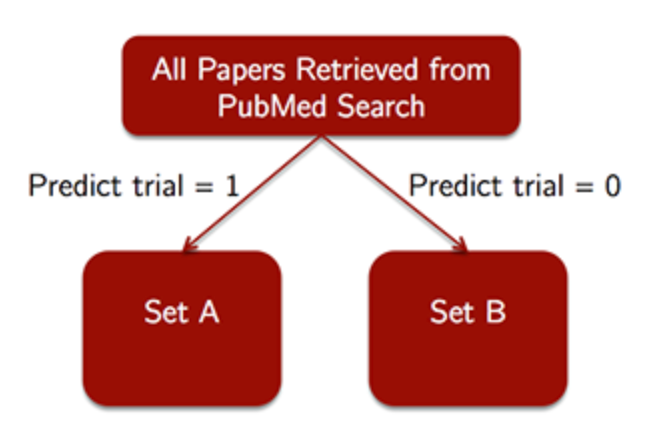

**Q1:** What is the cost associated with the model in Step 1 making a false negative prediction?

**A1**: A paper that should be in Set A will be missing. Thus affecting the results of step 3.


**Explanation:** 

By definition, a false negative is a paper that should have been included in Set A but was missed by the model. This means a study that should have been included in Step 3 was missed, affecting the results.

**Q2:** What is the cost associated with the model in Step 1 making a false positive prediction?

**A2**: Additional paper in set A > Additional work in step 1 . Results of step 3 not affected


**Explanation:** 

By definition, a false positive is a paper that should not have been included in Set A but that was actually included. However, because the manual review in Step 2 is assumed to be 100% effective, this extra paper will not make it into the more limited set of papers, and therefore this mistake will not affect the analysis in Step 3.

**Q3:** Given the costs associated with false positives and false negatives, which of the following is most accurate?

**A3**: A false negative is more costly than a false positive; the decision maker should use a probability threshold less than 0.5 for the machine learning model.


**Explanation:** 
A lower threshold is prefered in cases where false negatives are more costly than false positives, since we will make fewer negative predictions.